### Include External Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
from os.path import isfile, join
import time
from tqdm import tqdm

# __Import Data__

In [2]:
%%time
db_path = join('..', '..', '..', 'Data', 'kgw_data.h5')

with pd.HDFStore(db_path) as DB:
    print(list(DB.keys()),'\n--------------\n',DB.info(),'\n--------------\n',DB.items(),'\n--------------\n')
    
# Load process data
pi_df  = pd.read_hdf(db_path,key='pi_data' ,mode='r',format='t').sort_values("TIMESTAMP").reset_index(drop=True)
gt_df  = pd.read_hdf(db_path,key='gt_data' ,mode='r',format='t').sort_values("TIMESTAMP").reset_index(drop=True)
dcs_df = pd.read_hdf(db_path,key='dcs_data',mode='r',format='t').sort_values("TIMESTAMP").reset_index(drop=True)
all_df = pd.read_hdf(db_path,key='all_data',mode='r',format='t')

# Load weather and market data
eex_df= pd.read_hdf('../../../../AEM/Data/intraday_transactions.h5', key='eex', format='t')
weather_df  = pd.read_hdf('../../../../AEM/Data/weather_data.h5', key='measured_weather',  format='t')

ren_dict={"zeitstempel_von": "TIMESTAMP", "luftfeuchtigkeit_relativ": "Ambient Humidity"
         ,"luftdruck_hpa": "Ambient Pressure","grad_celsius": "Ambient Temperature"}

['/all_data', '/dcs_data', '/gt_data', '/pi_data'] 
--------------
 <class 'pandas.io.pytables.HDFStore'>
File path: ../../../Data/kgw_data.h5
/all_data            frame        (shape->[416315,746])
/dcs_data            frame        (shape->[403140,10]) 
/gt_data             frame        (shape->[43647,520]) 
/pi_data             frame        (shape->[403140,218]) 
--------------
 <generator object HDFStore.items at 0x7f84c79335c8> 
--------------

CPU times: user 26.2 s, sys: 4.1 s, total: 30.3 s
Wall time: 7.36 s


### Impute and Resample Weather Data

In [3]:
%%time
wdf=weather_df.drop(['wetterstation','zeitstempel_bis'],axis=1) #drop non neccesary rows
wdf=wdf.rename(columns=ren_dict)                                #rename keys
all_df=pd.merge(all_df,wdf,on='TIMESTAMP',how='outer')          #merge weather data to existing dataframe and fill up missing values with NaN

CPU times: user 9.6 s, sys: 1.19 s, total: 10.8 s
Wall time: 5.81 s


# Select your Features
Import CSV Sheet (Data_Selec.csv) with different Objectgroups, Tagnames, Descriptions, Min/Max Values and Units

In [4]:
slc_path = join('..', '..', '..', 'Data','INFO', 'Data_Selec.csv')
slc=pd.read_csv(slc_path, engine='c',sep=';')
ls=list(slc.Tagname); ls.insert(0,'TIMESTAMP'); # list of selected features

# go through Dataframes of different Sources (PI, GT, DCS...) and join the columns of selected Variables
dfa=all_df.loc[:,all_df.columns.isin(ls)].reset_index(drop=True); print("Shape of Dataselection:" ,dfa.shape)
slc=slc.set_index('Tagname');slc_dict=slc.to_dict();
slc

Shape of Dataselection: (416316, 28)


Objectgroup       Description     Min  \
Tagname                                                                         
120 A0 HHG01 CP001AXQ01                        AHDE       P_ErdGas_K7       0   
120 A0 HHG01 CT001AXQ01                        AHDE       T_ErdGas_K7     -10   
120 A5 HHG10 FF001XQ01                         AHDE     F_Gas_BrnGrp1       0   
120 A5 HHG13 FF001XQ01                         AHDE     F_Gas_BrnGrp2       0   
120 A5 LAB22 CP001XQ01                         AHDE    P_SpW_v_AbHKes       0   
120 A5 LAB30 CF901XQ01                         AHDE    F_SpW_v_AbHKes       0   
120 A5 LAB30 CT001XQ01                         AHDE    T_SpW_v_AbHKes       0   
120 A5 HAC10 CT001XQ01                         AHDE      T_SpW_hi_Eco       0   
120 A5 HAD10 CF001XQ01                         AHDE    F_Absalzung_K5       0   
120 A5 HAD10 AA101AXQ01                        AHDE     G_TromNotAblf       0   
120 A5 HAH10 CT013XQ01                         AHDE       T_Wd_h_ÜHz1       0   
120 A5 HAH10 AA001AXQ01                        AHDE   G_EinsprKü_ÜHz1       0   
120 A5 HAH10 CT921XQ01                         AHDE    T_HeiDa_v_ÜHz2       0   
120 A5 LBA10 CT004XQ01                         AHDE      T_Wd_hi_ÜHz2       0   
120 A5 LBA10 FF901XQ01                         AHDE    F_HeiDa_AbHKes       0   
120 A5 LBA10 CP901XQ01                         AHDE    P_HeiDa_AbHKes       0   
120 A5 LBH10 AA001AXQ01                        AHDE    G_AnfRV_AbHKes       0   
120 A5 HBK10 CT001XQ01                         AHDE        T_RG_hi_ZF       0   
120 A1 EKA10 FF001BXQ01                          GT  F_GT_HD-Stat_MU1       0   
120 A1 EKA20 FF001BXQ01                          GT  F_GT_HD-Stat_MU2       0   
120 A1 MKA10 CE001XQ01                           GT       GT_Leistung       0   
AN_T1_Average_Temperature                        GT        T1_Avg_Amb  -51,11   
AN_T5_Average_Temperature                        GT       T5_Avg_Turb  -17,78   
AN_T7_Average_Temperature                        GT      T7_Avg_Abgas  -17,78   
AN_Turbine_Air_Inlet_Collector_Press             GT            P1_Amb       0   
AN_Turbine_Exhaust_Press                         GT          P7_Abgas       0   
Ambient Humidity                      Wetterstation         R_Hum_Amb       0   

                                          Max      Unit  
Tagname                                                  
120 A0 HHG01 CP001AXQ01                     4  bar       
120 A0 HHG01 CT001AXQ01                    40  °C        
120 A5 HHG10 FF001XQ01                   2500  Nm³/h     
120 A5 HHG13 FF001XQ01                    900  Nm³/h     
120 A5 LAB22 CP001XQ01                    200  bar       
120 A5 LAB30 CF901XQ01                    100  t/h       
120 A5 LAB30 CT001XQ01                    120        °C  
120 A5 HAC10 CT001XQ01                    350        °C  
120 A5 HAD10 CF001XQ01                   3,45  t/h       
120 A5 HAD10 AA101AXQ01                   100  %         
120 A5 HAH10 CT013XQ01                    520        °C  
120 A5 HAH10 AA001AXQ01                   100  %         
120 A5 HAH10 CT921XQ01                    500  °C        
120 A5 LBA10 CT004XQ01                    550  °C        
120 A5 LBA10 FF901XQ01                    100  t/h       
120 A5 LBA10 CP901XQ01                    125  bar       
120 A5 LBH10 AA001AXQ01                   100  %         
120 A5 HBK10 CT001XQ01                   1000       °C   
120 A1 EKA10 FF001BXQ01                 15000  Nm³/h     
120 A1 EKA20 FF001BXQ01                 15000  Nm³/h     
120 A1 MKA10 CE001XQ01                     37  MW        
AN_T1_Average_Temperature               65,56        °C  
AN_T5_Average_Temperature             1093,33        °C  
AN_T7_Average_Temperature              815,56        °C  
AN_Turbine_Air_Inlet_Collector_Press     1,38      bara  
AN_Turbine_Exhaust_Press                 1,38      bara  
Ambient Humidity                          100         %

## Feature Transformation
Combining specific attributes 

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin

# Store sum over gasflow to GT and delete old measurements
dfa["F_ErdGas_GT"]=dfa["120 A1 EKA10 FF001BXQ01"]+dfa["120 A1 EKA20 FF001BXQ01"]
dfa=dfa.drop(columns=["120 A1 EKA10 FF001BXQ01","120 A1 EKA20 FF001BXQ01"]);

# Store sum over gasflow to ZF and delete old measurements
#dfa["F_ErdGas_ZF"]=dfa["F_Gas_BrnGrp1"]+dfa["F_Gas_BrnGrp2"]
#dfa=dfa.drop(columns=["F_Gas_BrnGrp1","F_Gas_BrnGrp2"]);
#Set Timestamp as Index
dfa.set_index('TIMESTAMP', inplace=True);
print("Shape of Dataselection:" ,dfa.shape)

Shape of Dataselection: (416316, 26)


# __Data Cleaning__
1) linear interpolate the GT data (fillup NaN from resample 10min-step)   
2) drop rows with still having NaN because of unbalanced classes

In [6]:
# Step 1: linear interpolate the missing values...
dfi=dfa.iloc[:,dfa.columns.isin(gt_df)].interpolate() #...of GT Data
dfi2=dfa.iloc[:,dfa.columns.isin(wdf)].interpolate() #...Weather Data

# update the Dataframe for the selected features
dfa.update(dfi); dfa.update(dfi2)

#Rename your columns with Description to make it more readable
dfa=dfa.rename(columns=slc_dict["Description"]);

# Step 2: drop rows with still missing values/ not full feature set
dfcl=dfa.dropna(axis=0,how='any')
print("\nLength of: \n - Original Dataframe \t\t", len(dfa),     
      "\n - removed unvalid rows \t", len(dfa)-len(dfcl),
      "\n - Cleaned Dataframe \t\t", len(dfcl));


Length of: 
 - Original Dataframe 		 416316 
 - removed unvalid rows 	 165001 
 - Cleaned Dataframe 		 251315


## Gain Insight which data misses

In [7]:
dfa_na = (dfa.isnull().sum() / len(dfa)) * 100
dfa_na = dfa_na.drop(dfa_na[dfa_na == 0].index).sort_values(ascending=False)[:]
missing_data = pd.DataFrame({'Missing Ratio' :dfa_na})
missing_data

Missing Ratio
R_Hum_Amb            19.600496
F_ErdGas_GT          18.162405
GT_Leistung           9.746202
P_SpW_v_AbHKes        5.259947
P_ErdGas_K7           5.259947
T_ErdGas_K7           5.259947
F_Absalzung_K5        5.259947
T_HeiDa_v_ÜHz2        5.259947
F_SpW_v_AbHKes        5.259947
T_SpW_v_AbHKes        5.259947
P_HeiDa_AbHKes        5.259947
T_Wd_hi_ÜHz2          5.259947
F_HeiDa_AbHKes        5.259947
G_AnfRV_AbHKes        5.259707
F_Gas_BrnGrp2         5.257785
G_TromNotAblf         5.254422
G_EinsprKü_ÜHz1       2.442616
T_RG_hi_ZF            2.420517
T_Wd_h_ÜHz1           2.420517
T_SpW_hi_Eco          2.420517
F_Gas_BrnGrp1         0.193603

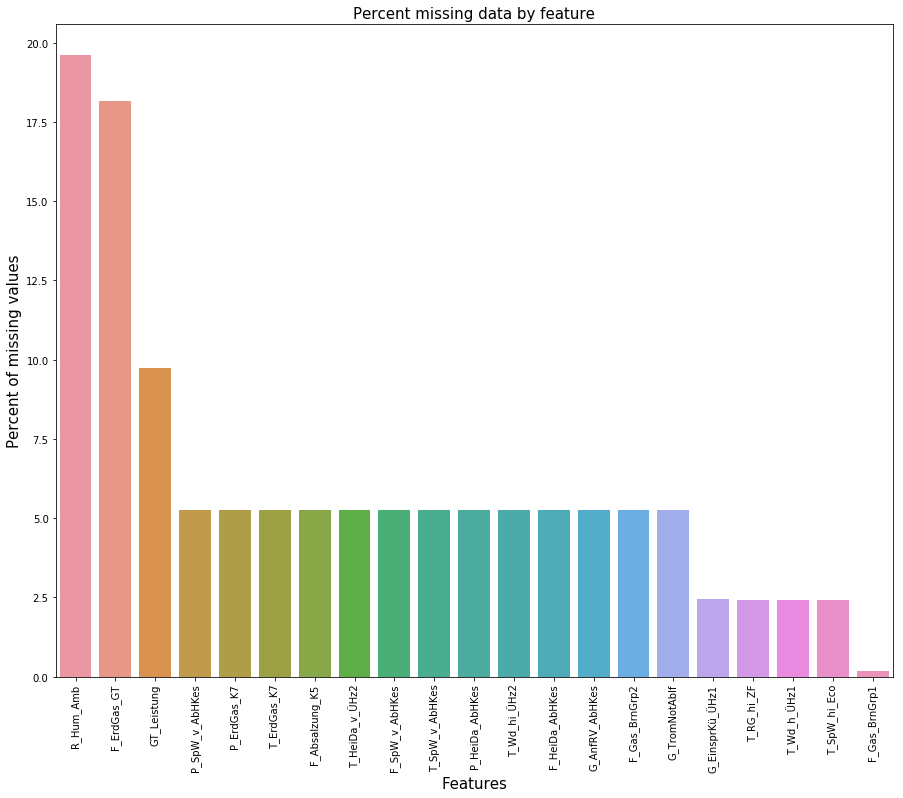

In [8]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=dfa_na.index, y=dfa_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15);

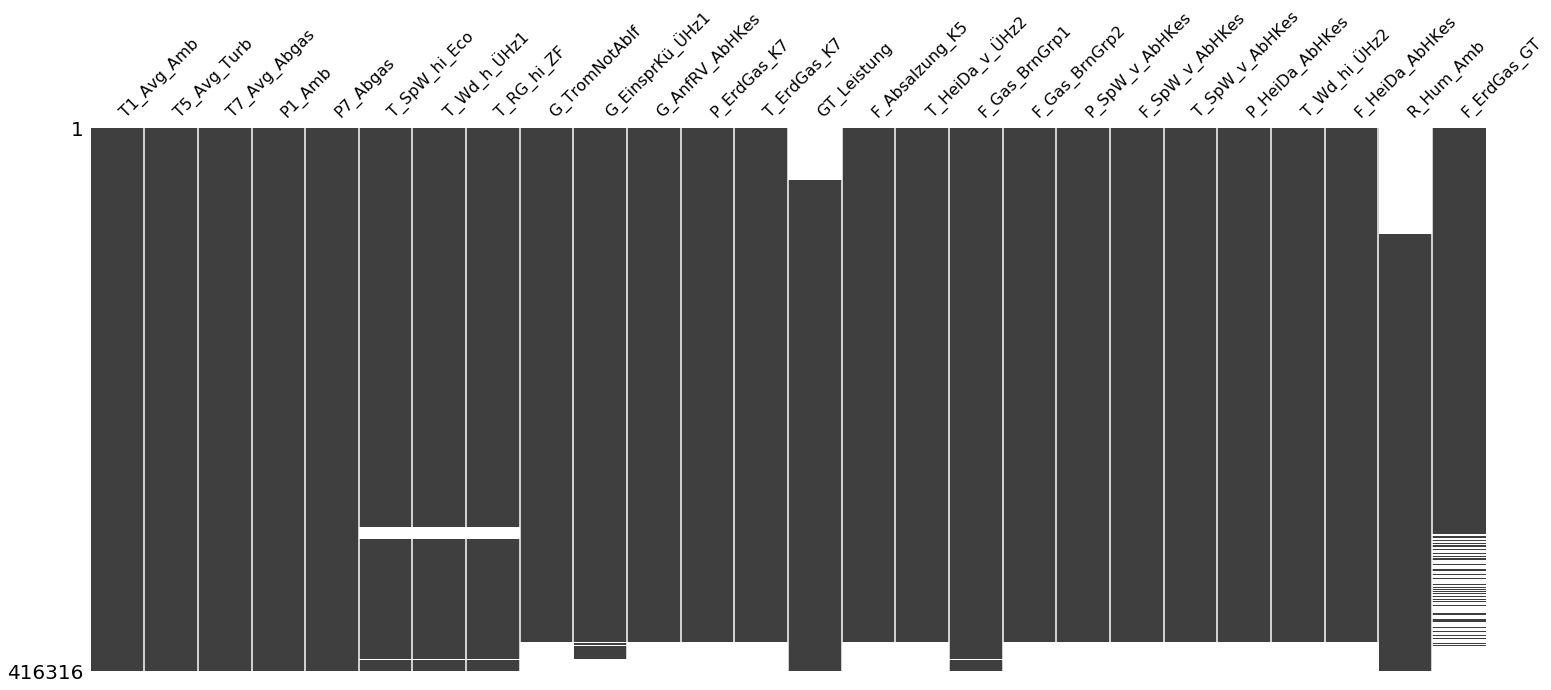

In [9]:
#sns.heatmap(dfa.isnull(),cbar=False)

import missingno as msno
msno.matrix(dfa,sparkline=False,)

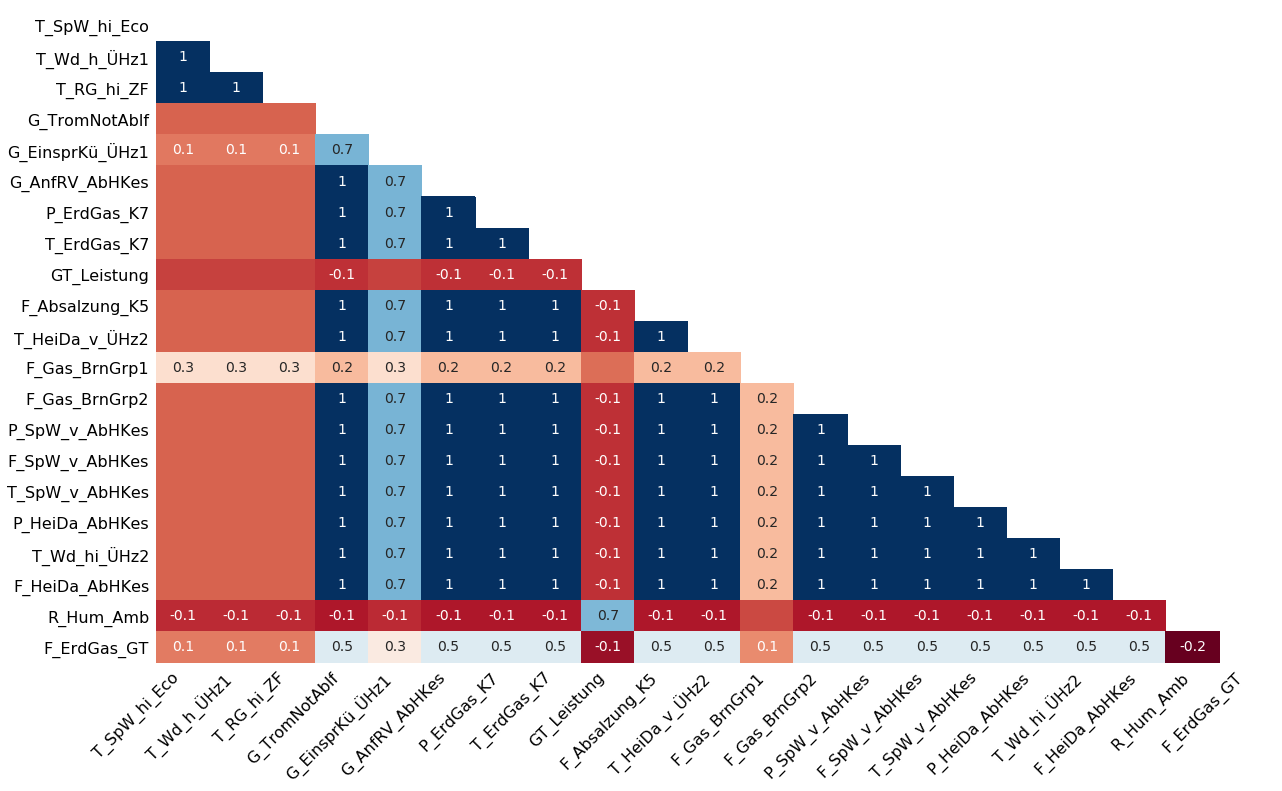

In [10]:
msno.heatmap(dfa)

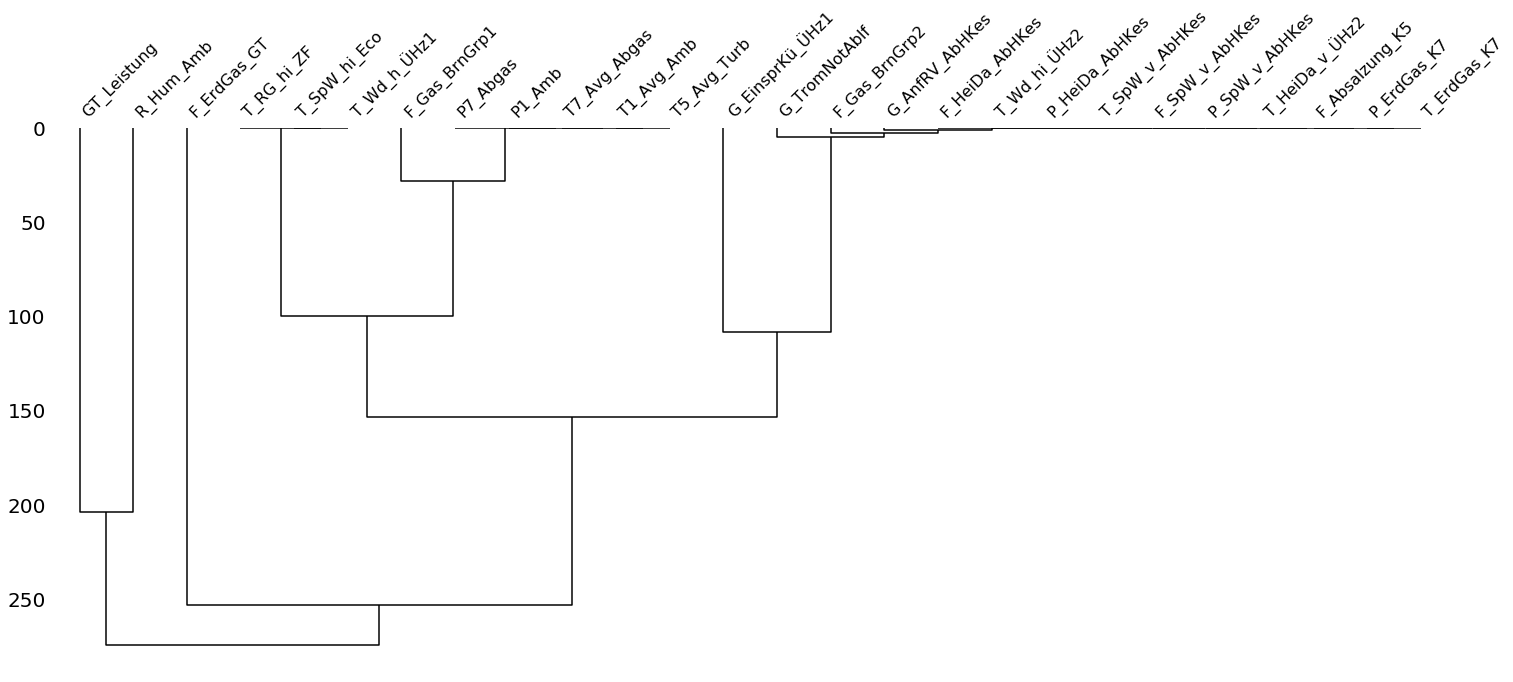

In [11]:
msno.dendrogram(dfa)

## Define different data filters 

In [12]:
def Filt_GT(dframe,threshold):
    dframe=dframe[dframe["GT_Leistung"]>threshold] #GT Power under certain threshold
    dframe=dframe[dframe['F_ErdGas_GT']>0] #GT Gas supply <0 filtered
    return dframe

def Filt_ZF(dframe,threshold):
    dframe=dframe[(dframe['F_Gas_BrnGrp1']+dframe['F_Gas_BrnGrp2'])>threshold]
    return dframe

#Set your threshold for Z-Score, 
#the Intuition behind Z-Score is to describe any data point by finding their relationship 
#with the Standarddeviation and Mean of the group of data points and drop rows refering to a setted threshold 
def Filt_ZScore(dframe,threshold):
    from scipy import stats
    import numpy as np
    return dframe[(np.abs(stats.zscore(dframe))<threshold).all(axis=1)]

## Choose you filters

In [13]:
# GT Filter
TH_GT=5; df=Filt_GT(dfcl,TH_GT); dfcl2=df.copy()
# AHDE/ ZF Filter
TH_AHDE=2; df=Filt_ZF(dfcl,TH_AHDE); dfcl3=df.copy()
# Z-Score Filter
TH_Z=3;  df=Filt_ZScore(dfcl,TH_Z); dfcl4=df.copy()

print("Original Number of Samples:\t " ,len(dfcl))
print("#Samples GT Power <= {} MW :\t ".format(str(TH_GT)), len(dfcl)-len(dfcl2))
print("#Samples Vdot ZF  <  {} Nm3/h :\t ".format(str(TH_AHDE)),len(dfcl)-len(dfcl3))
print("#Samples Z-Score  <  {}  :\t ".format(str(TH_Z)),len(dfcl)-len(dfcl4))
print("Shape of cleaned Dataframe:", df.shape)

Original Number of Samples:	  251315
#Samples GT Power <= 5 MW :	  10119
#Samples Vdot ZF  <  2 Nm3/h :	  10286
#Samples Z-Score  <  3  :	  17335
Shape of cleaned Dataframe: (233980, 26)


# __Compute Target__
## Steam- and Waterproperties

In [16]:
from iapws import IAPWS97
# Temperature, 273.15 < [K] < 1073.15 
# Pressure, 0.00061121 < [MPa] < 100
# https://iapws.readthedocs.io/en/latest/iapws.iapws97.html#iapws.iapws97.IAPWS97

# Feedwater  
T_SPW=np.array((df['T_SpW_v_AbHKes']+273.15)) 
P_SPW=np.array((df['P_SpW_v_AbHKes']/10)); 
F_SPW=np.array(df['F_SpW_v_AbHKes'])*(1000/3600); #t/h --> kg/s
spw_h=np.zeros(len(df));spw_s=np.zeros(len(df));spw_rho=np.zeros(len(df));spw_cp=np.zeros(len(df));spw_alph=np.zeros(len(df))

# Heating Steam 
T_FD=np.array((df['T_Wd_hi_ÜHz2']+273.15)) 
P_FD=np.array((df['P_HeiDa_AbHKes']/10)); 
F_FD=np.array(df['F_HeiDa_AbHKes'])*(1000/3600); 
fd_h=np.zeros(len(df));fd_s=np.zeros(len(df));fd_rho=np.zeros(len(df));fd_cp=np.zeros(len(df));fd_alph=np.zeros(len(df))

#Compute Fluid Properties according IAPWS97
for i in tqdm(range(len(df)),desc='Processing record'):
    spw=IAPWS97(T=T_SPW[i],P=P_SPW[i])
    fd=IAPWS97(T=T_FD[i],P=P_FD[i])
    #Set Properties to np.Arrays
    spw_h[i]=spw.h; spw_s[i]=spw.s; spw_rho[i]=spw.rho; spw_cp[i]=spw.cp; spw_alph[i]=spw.alfa    
    fd_h[i]=fd.h; fd_s[i]=fd.s; fd_rho[i]=fd.rho; fd_cp[i]=fd.cp; fd_alph[i]=fd.alfa
    
# Create new Dataframe with all calculated Properties   
df_SPW=pd.DataFrame({'E':spw_h*F_SPW,'T':T_SPW,'P':P_SPW,'h':spw_h,'s':spw_s,'rho':spw_rho,'cp':spw_cp,'alpha':spw_alph,'mdot':F_SPW}); df_SPW=df_SPW.set_index(df.index);
df_FD=pd.DataFrame({'E':fd_h*F_FD,'T':T_FD,'P':P_FD,'h':fd_h,'s':fd_s,'rho':fd_rho,'cp':fd_cp,'alpha':fd_alph,'mdot':F_FD}); df_FD=df_FD.set_index(df.index);

Processing record: 100%|██████████| 233980/233980 [05:35<00:00, 697.33it/s]


## Humid Air Properties

In [17]:
from CoolProp.HumidAirProp import HAPropsSI
# Temperature, 130 < [K] < 623.15
# Pressure, 10 < [Pa] < 1e+7 
# Humidity Ratio, 0 < W < 10 [kg w / kg dry Air]
#http://www.coolprop.org/fluid_properties/HumidAir.html

#Air Inlet/Freshair 
T_amb=np.array((df['T1_Avg_Amb']+273.15));
p_amb=np.array((df['P1_Amb']*1e5));
r_amb=np.array((df['R_Hum_Amb']/100));
h_wet=np.zeros(len(df));s_wet=np.zeros(len(df));cp_wet=np.zeros(len(df))

#Compute Air Properties according ASHRAE RP-1485
for i in tqdm(range(len(df)),desc='Processing record'):
    Hha=HAPropsSI('Hha','T',T_amb[i],'P',p_amb[i],'R',r_amb[i]);
    Sha=HAPropsSI('Sha','T',T_amb[i],'P',p_amb[i],'R',r_amb[i]);
    Cha=HAPropsSI('Cha','T',T_amb[i],'P',p_amb[i],'R',r_amb[i]);
    h_wet[i]=Hha; s_wet[i]=Sha; cp_wet[i]=Cha;
    
# Create new Dataframe with all calculated Properties   
df_FA=pd.DataFrame({'T':T_amb,'P':p_amb,'R':r_amb,'h':h_wet/1000,'s':s_wet,'cp':cp_wet}); df_FA=df_FA.set_index(df.index);

Processing record: 100%|██████████| 233980/233980 [05:41<00:00, 685.75it/s]


## GT Flue Gas Properties

In [18]:
# Average Flue Gas Values from "GT_Lastfälle" Chart
#H20_Ave=5.895862069; CO2_Ave=2.6; N2_Ave=75.40448276; O2_Ave=15.19482759; Ar_Ave=0.90121;
T_fg=np.array((df['T7_Avg_Abgas']+273.15));
p_fg=np.array((df['P7_Abgas']*1e5));

import CoolProp.CoolProp as CP  #CP.PropsSI('C')
import cantera as ct
# Implementation of GRI-Mech 3.0, 53-Species, 325-reaction natural gas combustion mechanism 
# http://www.me.berkeley.edu/gri_mech/ 
g=ct.Solution('gri30.xml')

#read fluegas composites from "GT_lastfälle" for given conditions X_AG=f(Pel, T_amb, X_H2_max_Gas)
FG_Vali=pd.read_csv(join('..', '..', '..', 'Data','INFO', 'AG_GT_Lastfälle.csv'),decimal=',', index_col='Lastfälle',engine='c',sep=';')
fg_comp=FG_Vali.loc[:,"H2O":"Ar"].dropna(axis=0,how='any').values
cp_fg=np.zeros((len(df),len(fg_comp))); h_fg=np.zeros((len(df),len(fg_comp))); s_fg=np.zeros((len(df),len(fg_comp))); roh_fg=np.zeros((len(df),len(fg_comp)));

#thermodynamics requires two properties in addition to composition information
for j in tqdm(range(len(df))):
    for i in range(len(fg_comp)):
        g.TPX = T_fg[j], p_fg[j], {'H2O':fg_comp[i,0],'CO2':fg_comp[i,1],'N2':fg_comp[i,2],'O2':fg_comp[i,3],'Ar':fg_comp[i,4]};
        cp_fg[j,i]=g.cp_mass; h_fg[j,i]=g.enthalpy_mass
        s_fg[j,i]=g.entropy_mass; roh_fg[j,i]=g.density
        
#compute exhaust gas enthalpy according to average heat capacity 
fg_h7=np.zeros(len(df));
cp_ave=cp_fg.mean()
for i in tqdm(range(len(df))):
    fg_h7[i]=cp_ave*(T_fg[i]-273.15)/1000
    
# Create new Dataframe with all calculated Properties   
df_FG=pd.DataFrame({'T':T_fg,'P':p_fg,'h':fg_h7,'cp':cp_fg.mean(axis=1),'s':s_fg.mean(axis=1)}); df_FG=df_FG.set_index(df.index);

100%|██████████| 233980/233980 [00:00<00:00, 1252323.42it/s]


### Compute Generator Efficiency
Eta_G = f(PF, Pel); The generator efficiency depends on the electrical poweroutput and the power factor. This can be interpolated via the manufacturer's guaranteed spedifications. For further calculations a fixed efficiancy value is asumed representing the standard GT operation conditions.     

__Asumption : 98.5 %__ 

In [19]:
#from scipy.optimize import curve_fit
#ETA_Gen=pd.read_csv(join('..', '..', '..', 'Data','INFO', 'Eta_Gen.csv'), decimal=',',engine='c',sep=';')
#Eta=ETA_Gen['Eta_G']; Pel=ETA_Gen['Pel']; PF=ETA_Gen['PF'];
eta_g=0.985;

## Compute ernergy balance at Gasturbine
to get Freshair Massflow

In [20]:
# Import Gas Analysis from Badenova 2017. Assuming same natural gas properties
Gas_comp=pd.read_csv(join('..', '..', '..', 'Data','INFO', '2017_GasAnalysis.csv'), decimal=',',engine='c',sep=';') # Hu in [kWh/Nm3], roh_GT in [kg/Nm3]
roh_Gas=Gas_comp["Normdichte"].mean()
Hu=(Gas_comp["Heizwert"].mean()*3600)/roh_Gas; # 1 kWh/Nm3-->3600 kJ/kg
Pel=df["GT_Leistung"]*1000; # 1 MW-->1000 kW
mFu=((df['F_ErdGas_GT'])*roh_Gas)/3600; # Nm3/h-->kg/s
FWL_GT=mFu*Hu;
mZF=((df['F_Gas_BrnGrp1']+df['F_Gas_BrnGrp2'])*roh_Gas)/3600; 
FWL_ZF=mZF*Hu;

#Set fixed Values for losse 
Pm_V=200; #200 kW of mechanical losses because of dissipation and fraction
Qv_GT=100; #100 kW thermal losses 

#Energy Balance solved for Freshair Massflow
mFA= (mFu*(Hu-df_FG['h'])-(Pel/eta_g)-Pm_V-Qv_GT)/(df_FG['h']-df_FA['h'])

#Set the computed values to existing Dataframes
df_FA["E"]=mFA*df_FA["h"]; df_FG["E"]=(mFA+mFu)*df_FG["h"];
df_FA["mdot"]=mFA ; df_FG["mdot"]=(mFA+mFu);

## Store calculated Fluid Properties in new HDF5 File ("fluid_properties.h5")

In [21]:
with pd.HDFStore(join('..', '..', '..', 'Data', 'fluid_properties.h5')) as DB:
    DB.put(key='SPW',  value=df_SPW) #Speisewasser
    DB.put(key='FD',  value=df_FD)   #Frischdampf
    DB.put(key='FG',  value=df_FG)   #Fluegas
    DB.put(key='FA',  value=df_FA)   #Freshair
    DB.put(key='FWL', value=pd.DataFrame({'GT':FWL_GT.values,'ZF':FWL_ZF.values,'Hu':Hu}))

## Read Fluid Properties 
Skip Steps above if allready computed and no new Filter was implemented

In [22]:
path=join('..', '..', '..', 'Data', 'fluid_properties.h5')
df_FA  = pd.read_hdf(path,key='FA' ,mode='r',format='t')
df_FG  = pd.read_hdf(path,key='FG' ,mode='r',format='t')
df_FD = pd.read_hdf(path,key='FD',mode='r',format='t')
df_SPW = pd.read_hdf(path,key='SPW',mode='r',format='t')
df_FWL = pd.read_hdf(path,key='FWL',mode='r',format='t')

## Compute AHDE Efficiency

In [49]:
mZF=((df['F_Gas_BrnGrp1']+df['F_Gas_BrnGrp2'])*roh_Gas)/3600; FWL_ZF=mZF*Hu;
eta_AHDE = (df_FD['E']-df_SPW['E']) / (df_FG['E']+FWL_ZF)
target=eta_AHDE

## Quick Look at the Calculated Efficieny
If necessary detect and remove some outliers , eg. eta > 1 @ 2018-04-12 ~ 14:00

False    233978
True          2
dtype: int64

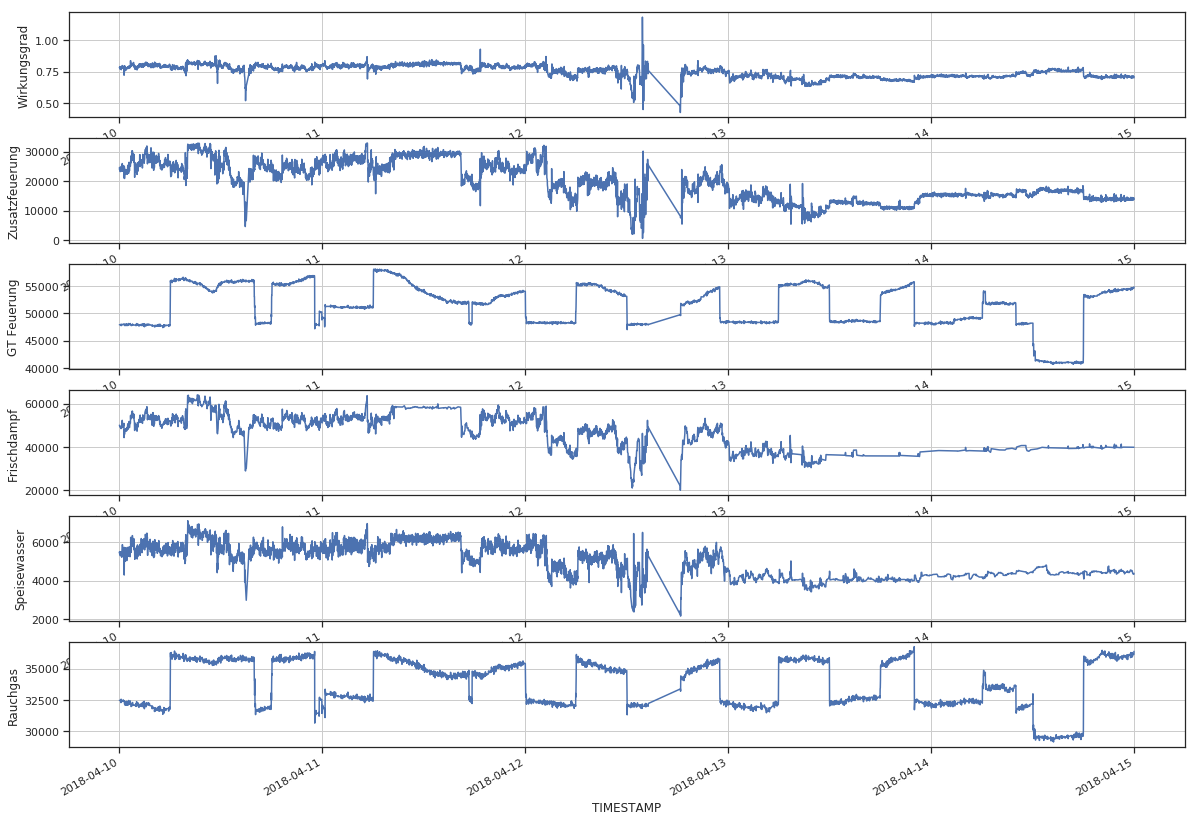

In [41]:
pltdf=pd.DataFrame({'Wirkungsgrad':eta_AHDE.values,'Zusatzfeuerung':FWL_ZF,'GT Feuerung':FWL_GT,'Frischdampf':df_FD['E'].values,
                    'Speisewasser':df_SPW['E'].values,'Rauchgas':df_FG['E'].values})

fig, axes = plt.subplots(len(pltdf.columns),1)
pltdf2=pltdf['2018-04-10':'2018-04-14']
for i in range(len(pltdf.columns)):  
    ax=pltdf2.iloc[:,i].plot(ax=axes[i], figsize=(20,15),grid=True)
    ax.set_ylabel(pltdf.columns[i])
    
#fig=ax.get_figure()
#plot_path=join('..', '..', '..','Plots', 'AHDE_Eff_20180412_Anomaly.pdf')
#fig.savefig(plot_path)
pd.value_counts(eta_AHDE>1)

CPU times: user 8min 40s, sys: 800 ms, total: 8min 40s
Wall time: 8min 40s


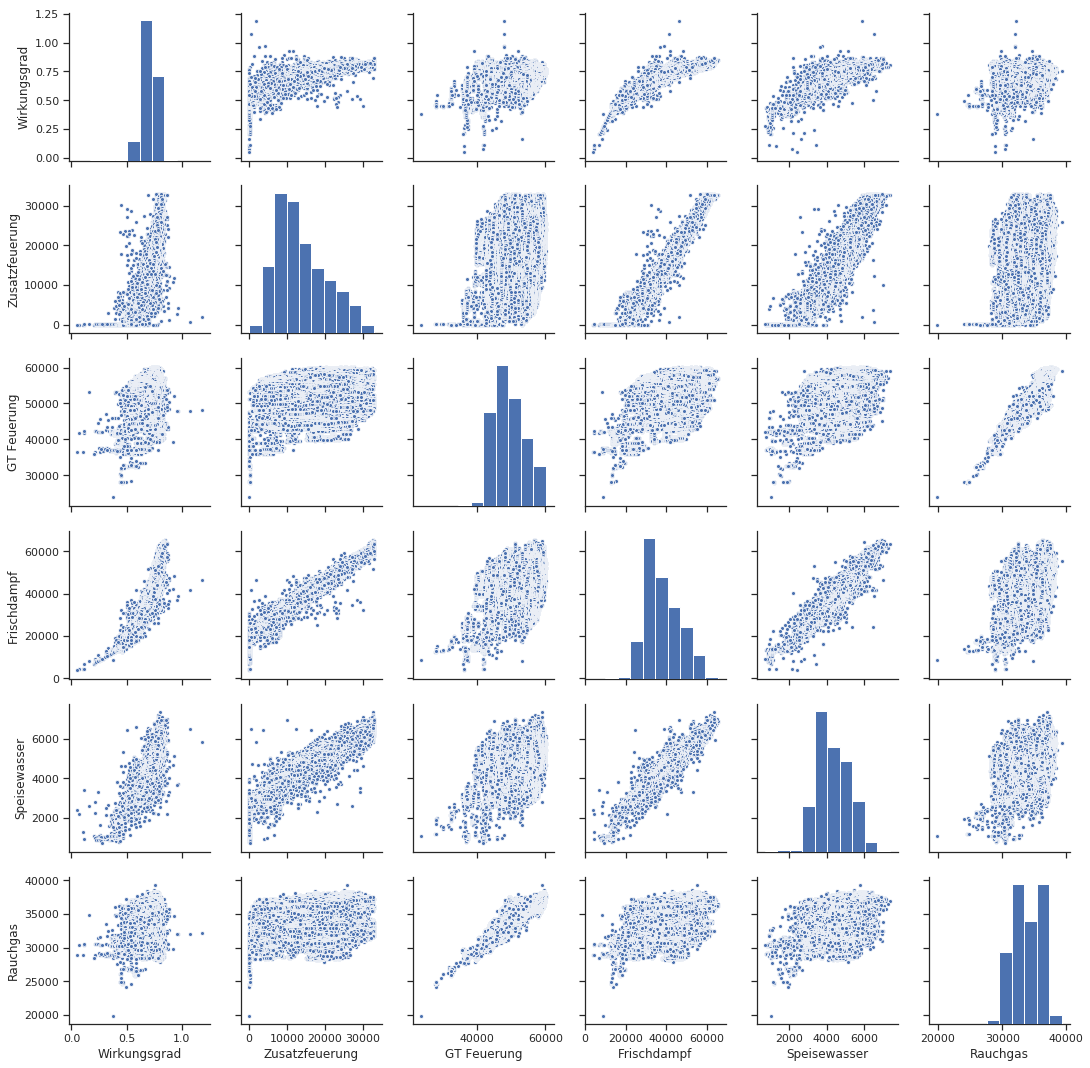

In [25]:
%%time
import seaborn as sns
sns.set(style="ticks", color_codes=True)
g=sns.pairplot(pltdf,plot_kws={"s": 15})
#Save the figure
plot_path=join('..', '..', '..','Plots', 'Scatter_AHDE_Eff111.pdf')
g.savefig(plot_path)

## Explore your Dataselection

In [42]:
%%time
df.describe()

CPU times: user 216 ms, sys: 20 ms, total: 236 ms
Wall time: 234 ms


T1_Avg_Amb    T5_Avg_Turb   T7_Avg_Abgas         P1_Amb  \
count  233980.000000  233980.000000  233980.000000  233980.000000   
mean       16.612127     738.934204     458.404022       0.973702   
std         7.367701      20.766541      12.672559       0.007593   
min        -6.717680     391.451965     404.865265       0.950040   
25%        11.924225     717.984650     449.659729       0.969900   
50%        17.429929     740.206909     458.909698       0.975200   
75%        21.822762     759.944580     468.061211       0.978500   
max        35.379349     761.221985     533.736084       0.990960   

            P7_Abgas   T_SpW_hi_Eco    T_Wd_h_ÜHz1     T_RG_hi_ZF  \
count  233980.000000  233980.000000  233980.000000  233980.000000   
mean        0.987982     301.763306     470.413666     598.947632   
std         0.006789      11.652641      18.431725      53.743382   
min         0.966500     213.814972     343.719910     405.099915   
25%         0.984920     293.894958     457.183777     556.299805   
50%         0.989550     304.254944     468.571838     590.799927   
75%         0.992700     311.254944     482.299805     640.099854   
max         1.005900     322.174927     526.655884     746.999878   

       G_TromNotAblf  G_EinsprKü_ÜHz1      ...        F_Gas_BrnGrp1  \
count  233980.000000    233980.000000      ...        233980.000000   
mean        0.042808        29.205620      ...          1097.599365   
std         0.367302        19.347935      ...           468.826874   
min        -0.600000        -0.200000      ...             0.000000   
25%         0.000000        16.001379      ...           789.054993   
50%         0.100000        26.100000      ...          1051.524353   
75%         0.200000        44.059413      ...          1385.588684   
max        36.530781        88.309624      ...          2401.908691   

       F_Gas_BrnGrp2  P_SpW_v_AbHKes  F_SpW_v_AbHKes  T_SpW_v_AbHKes  \
count  233980.000000   233980.000000   233980.000000   233980.000000   
mean      243.255066      153.766251       43.317238       83.442070   
std       246.053360        2.007944        8.778089        2.124818   
min        -0.240000      116.507767        7.244126       76.984818   
25%         0.048821      152.659973       36.668312       81.773228   
50%       249.688599      154.239960       41.707010       83.376884   
75%       453.769257      155.063251       49.643998       84.719252   
max       799.566650      169.199982       74.831078       93.914864   

       P_HeiDa_AbHKes   T_Wd_hi_ÜHz2  F_HeiDa_AbHKes      R_Hum_Amb  \
count   233980.000000  233980.000000   233980.000000  233980.000000   
mean       107.519730     506.563873       40.561176      67.851328   
std          2.868973       8.639270        8.928677      17.713081   
min         47.974991     330.549866        4.171000      21.300000   
25%        105.208027     505.210136       33.782616      53.954905   
50%        108.001785     509.524170       38.654787      68.850000   
75%        109.829405     510.564896       46.989707      82.923333   
max        115.787476     537.789917       69.363800     100.000000   

         F_ErdGas_GT  
count  233980.000000  
mean     4836.557129  
std       423.830841  
min      2312.831543  
25%      4573.500000  
50%      4771.500000  
75%      5121.000000  
max      5845.620605  

[8 rows x 26 columns]

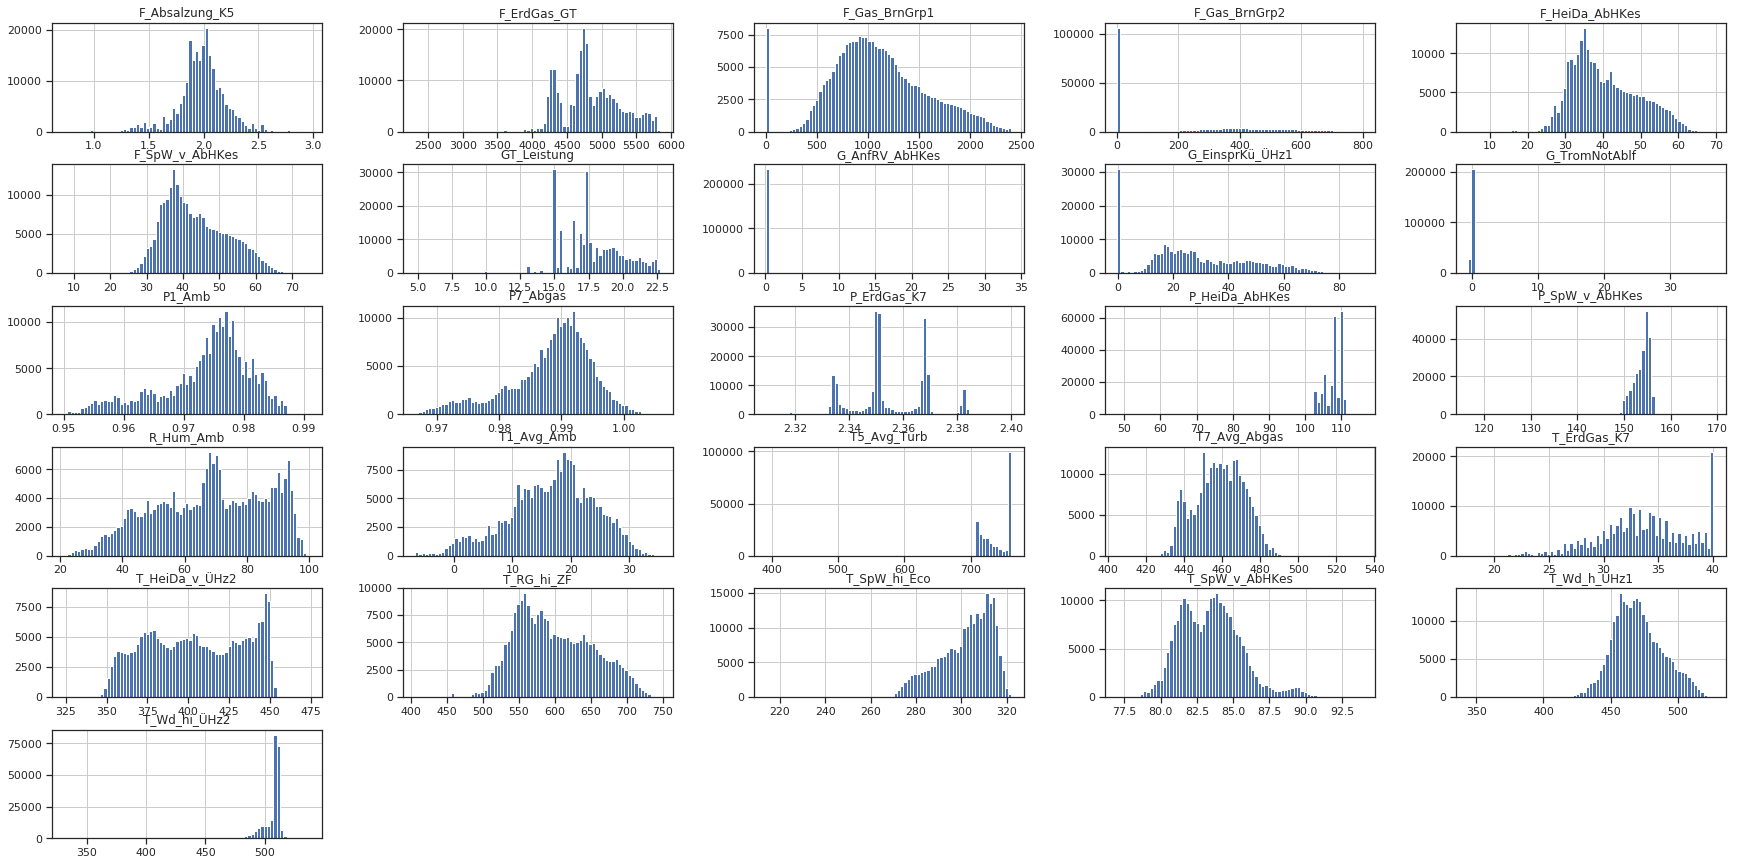

CPU times: user 5.98 s, sys: 56 ms, total: 6.04 s
Wall time: 6.03 s


In [43]:
%%time
df.hist(bins=75, figsize=(30,15))
plt.show()

CPU times: user 406 ms, sys: 24.1 ms, total: 430 ms
Wall time: 428 ms


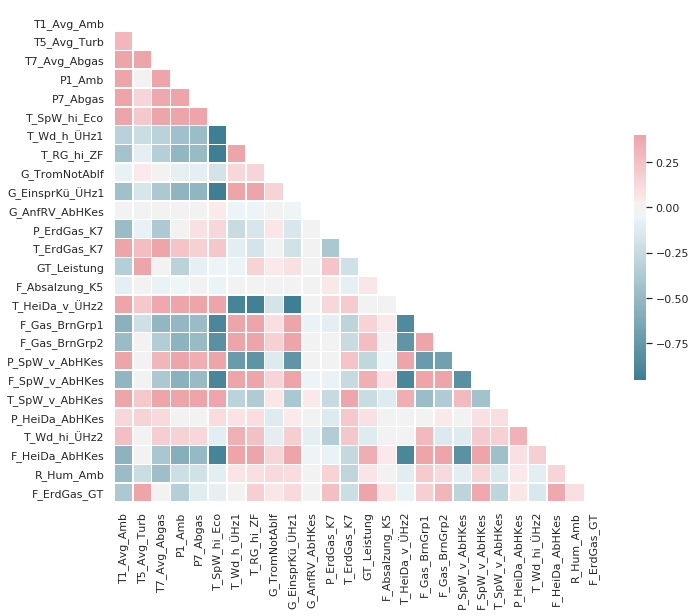

In [44]:
%%time
sns.set(style='white')
# Compute the correlation Matrix
corr=df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.4, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

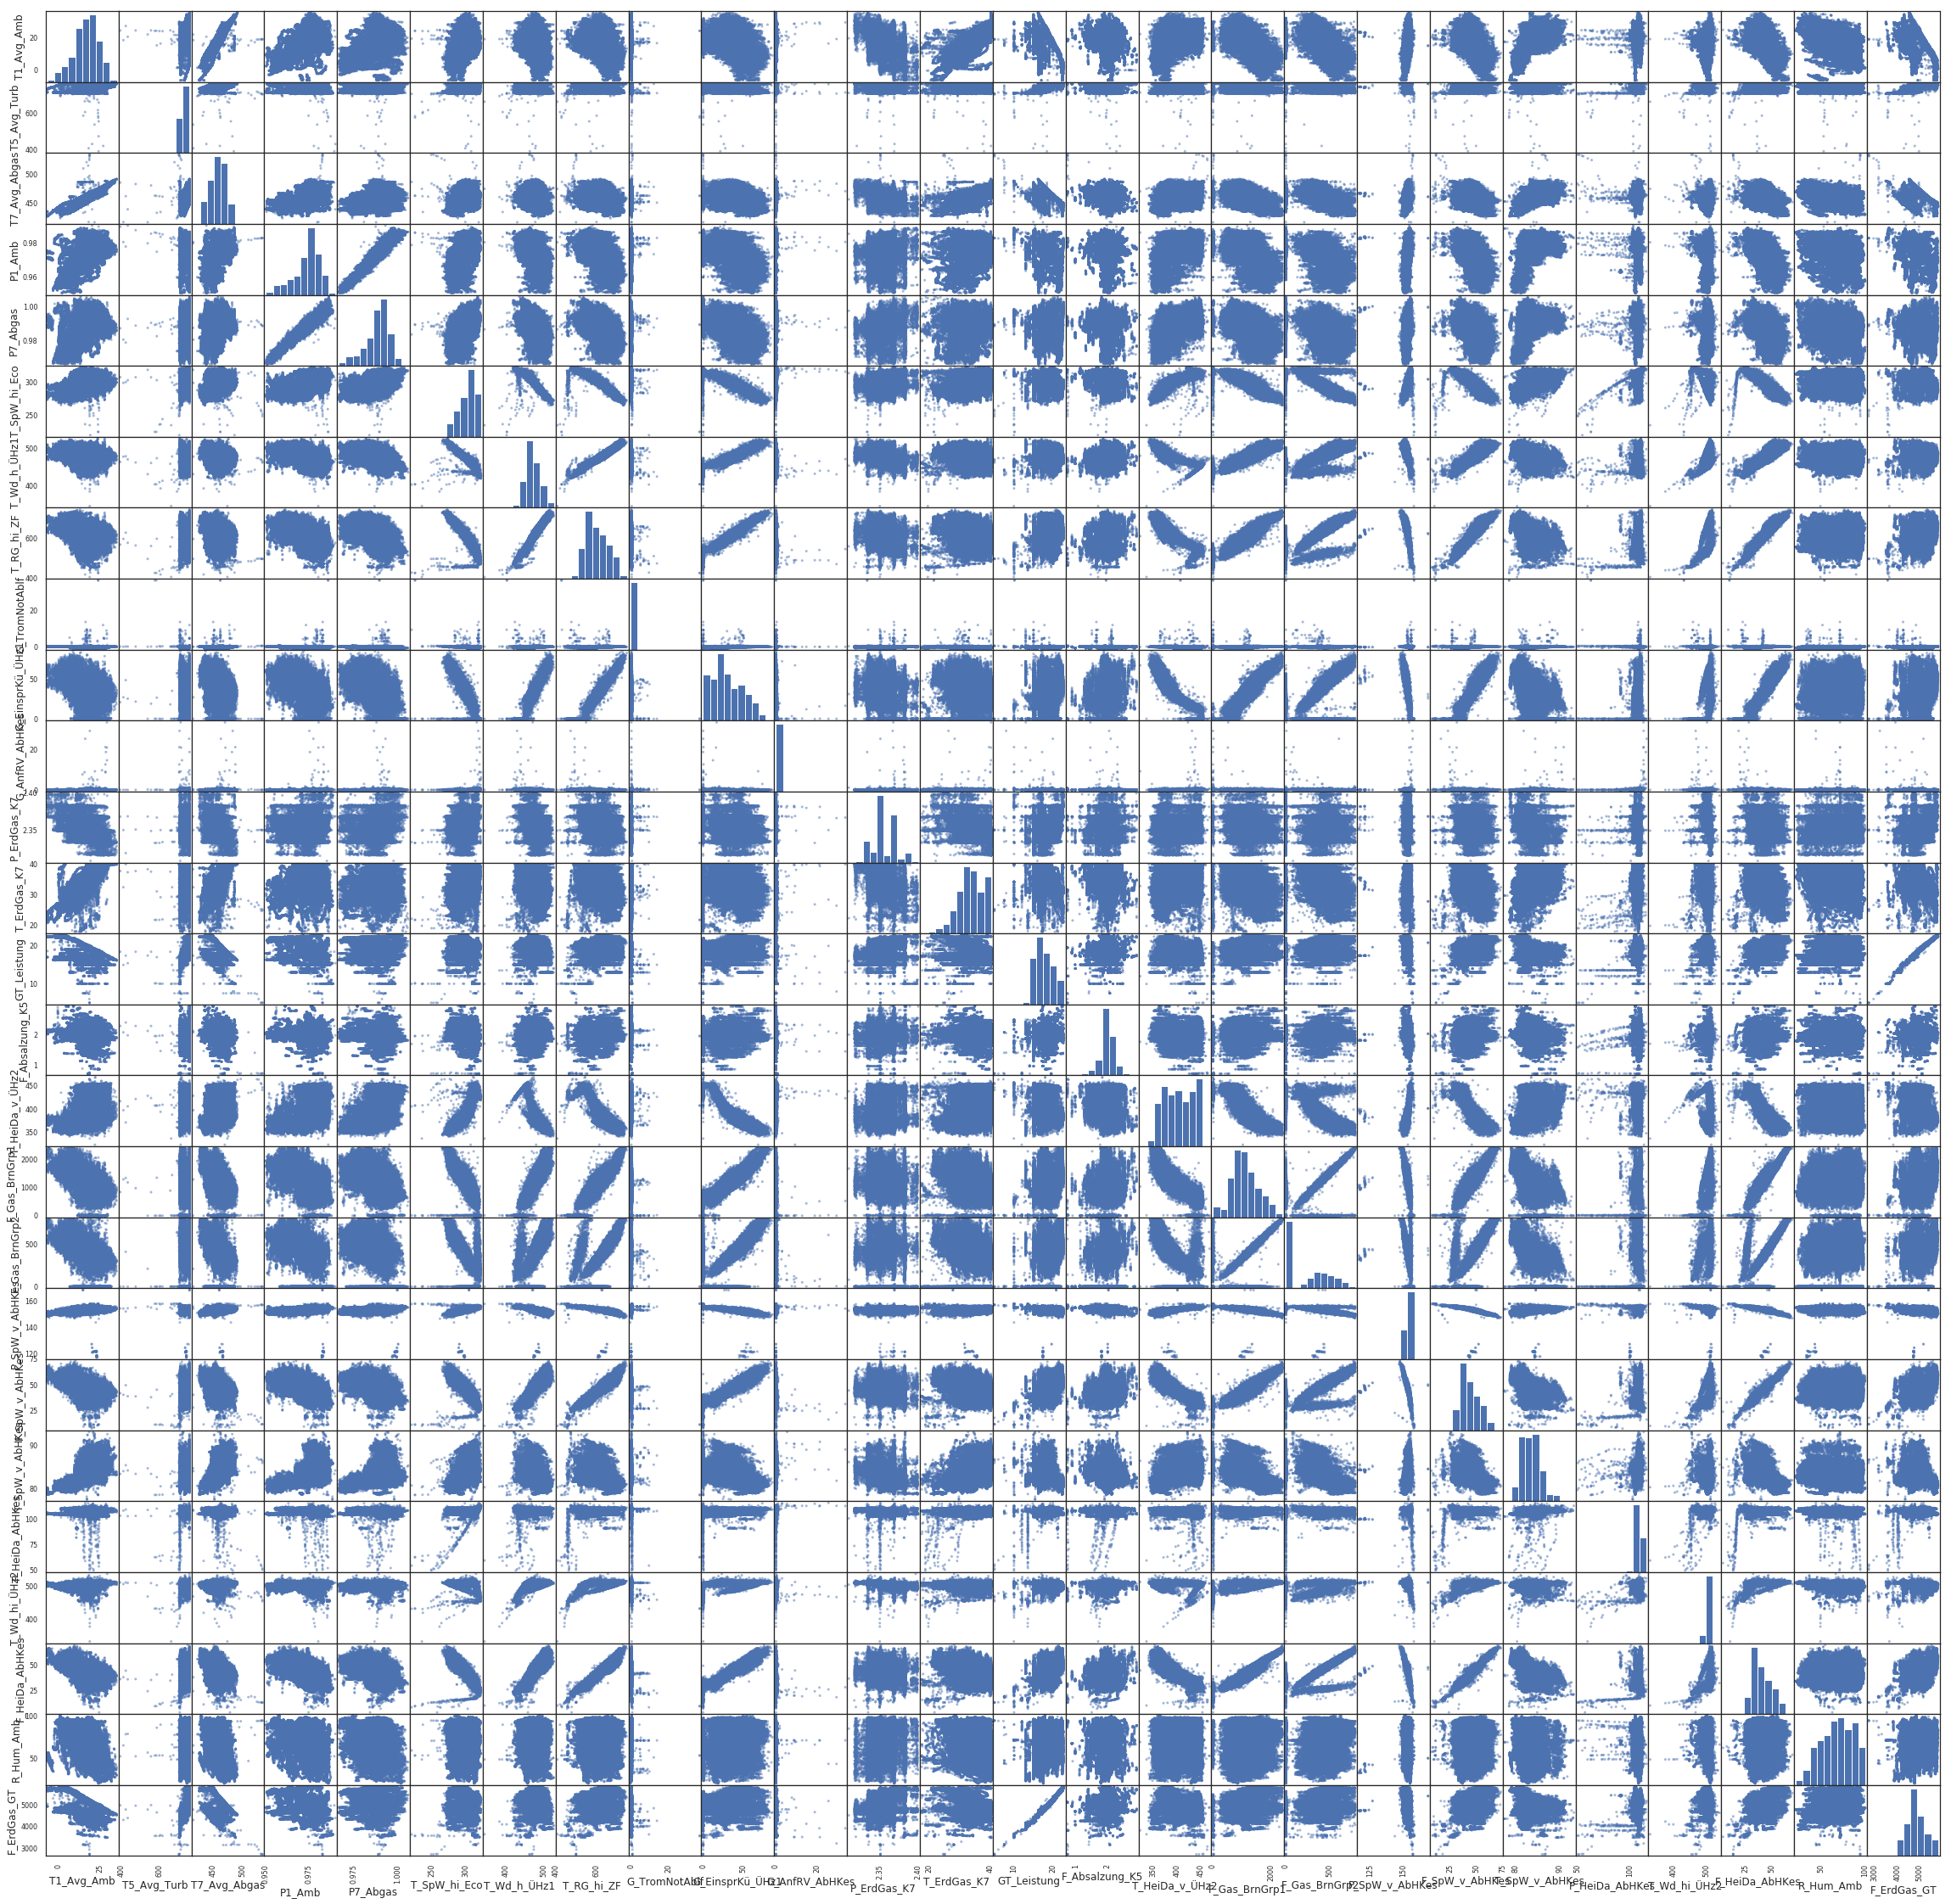

CPU times: user 6min 33s, sys: 1.44 s, total: 6min 35s
Wall time: 6min 35s


In [45]:
%%time
df_ele = df.sample(frac=0.2)
from pandas.plotting import scatter_matrix
scatter_matrix(df_ele,figsize=(40,40))
plt.show()

## Feature Scaling
Normalization vs. Standardization, most algorithms often expect input values ranging from 0 to 1

In [46]:
from sklearn.preprocessing import RobustScaler
transformer = RobustScaler().fit(df)
Xtrans=transformer.transform(df)

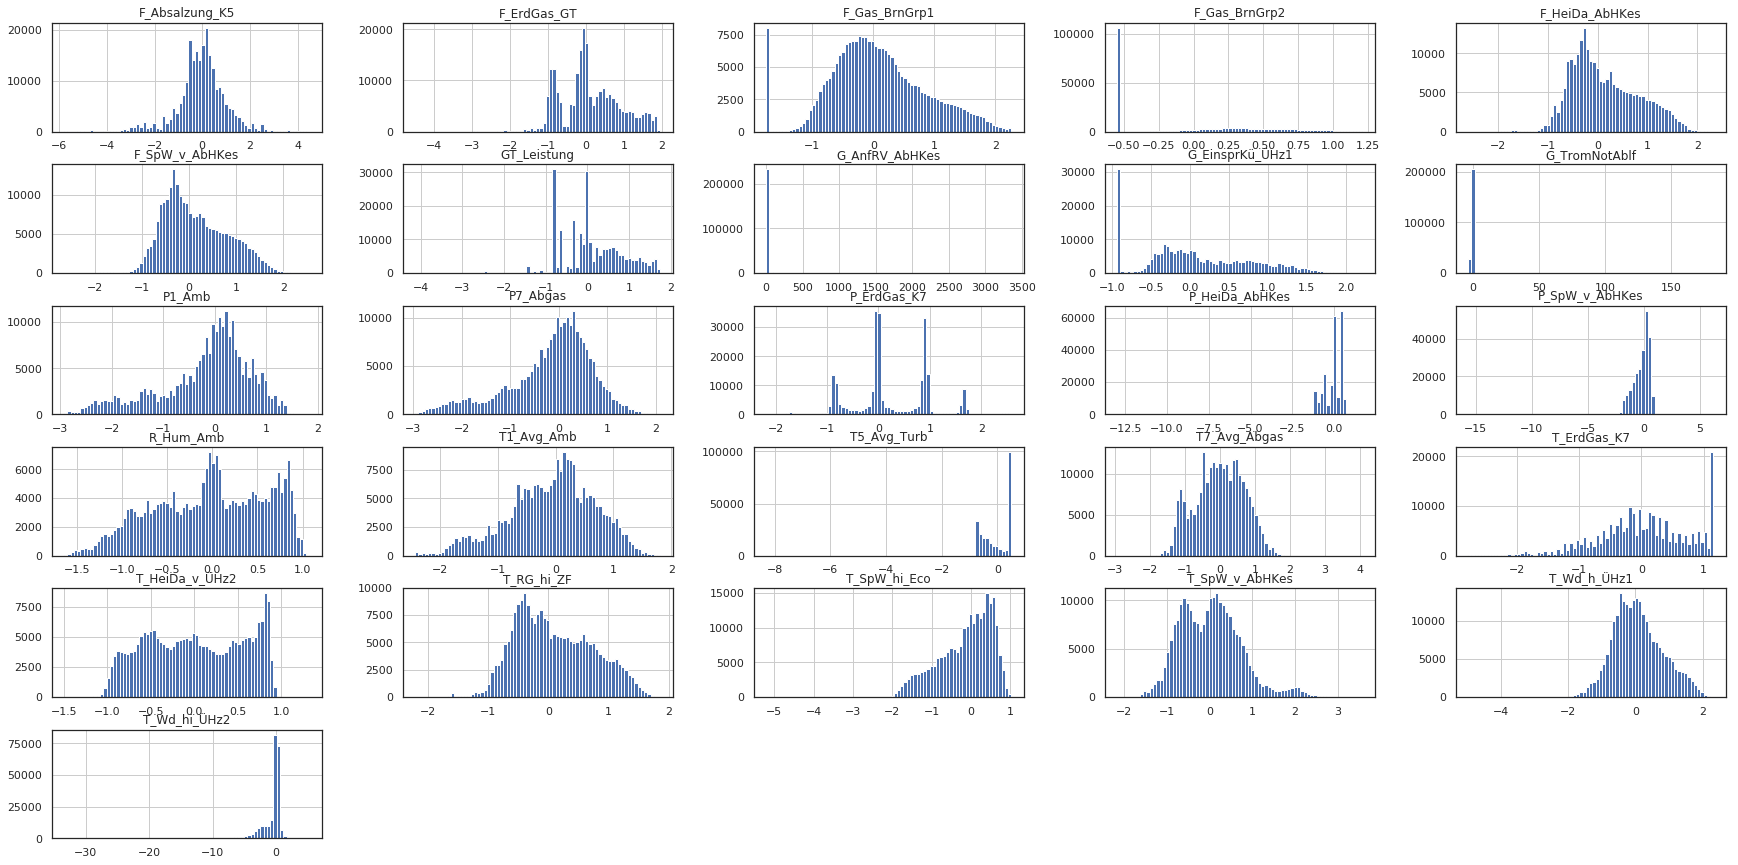

CPU times: user 6.94 s, sys: 100 ms, total: 7.04 s
Wall time: 6.56 s


In [47]:
%%time
df_scaled=pd.DataFrame(Xtrans, columns=df.dtypes.index)
df_scaled.hist(bins=75, figsize=(30,15))
plt.show()

## Create a Train, Validation and Testset

In [50]:
from sklearn.model_selection import train_test_split
# first split into Train- and Testset ()
X_train, X_test, y_train, y_test = train_test_split(df_scaled,target, test_size=0.2, random_state=1)

## Try to detect Outliers
with unlabeled Data

In [ ]:
%%time
from PyNomaly import loop
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.6, min_samples=len(df)/1000).fit(df)
m = loop.LocalOutlierProbability(df).fit()
score_noclu = m.local_outlier_probabilities
m_clust = loop.LocalOutlierProbability(df, cluster_labels=list(db.labels_)).fit()
score_clu = m_clust.local_outlier_probabilities


In [ ]:
df_clus =pd.DataFrame(df.copy())
df_clus['scores']=scores_clu
df_clus['labels']=db.lables_
df['scores']=score_noclu

df=df.sample(frac=0.1)
df_clus=df_clus.sample(frac=0.1)